 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,  выберите оптимальное значение.

 2. Примените нормализацию данных. Исследуйте скорость сходимости.

 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.

 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
 https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
 https://pytorch.org/docs/stable/optim.html

6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [1]:
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

df = pd.read_csv('weatherAUS.csv')
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']
df = df[cols]
df.dropna(inplace=True)
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)

X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).squeeze()
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).squeeze()

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, activation=nn.ReLU, init_fn=None):
        super(Net, self).__init__()
        self.layers = []
        last_size = input_size

        for hidden_size in hidden_layers:
            layer = nn.Linear(last_size, hidden_size)
            if init_fn:
                init_fn(layer.weight)
            self.layers.append(layer)
            self.layers.append(activation())
            last_size = hidden_size

        self.layers.append(nn.Linear(last_size, 1))
        self.layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)


In [7]:
def train_solve(net, optimizer_class, lr, epochs, criterion, device):
    net.to(device)
    X_train_device = X_train.to(device)
    y_train_device = y_train.to(device)
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)

    optimizer = optimizer_class(net.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        net.train()
        optimizer.zero_grad()
        y_pred = net(X_train_device).squeeze()
        loss = criterion(y_pred, y_train_device)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test_device).squeeze()
            test_loss = criterion(y_test_pred, y_test_device)
            test_losses.append(test_loss.item())
            accuracy = ((y_test_pred >= 0.5).int() == y_test_device.int()).float().mean().item()
            accuracies.append(accuracy)

    return train_losses, test_losses, accuracies

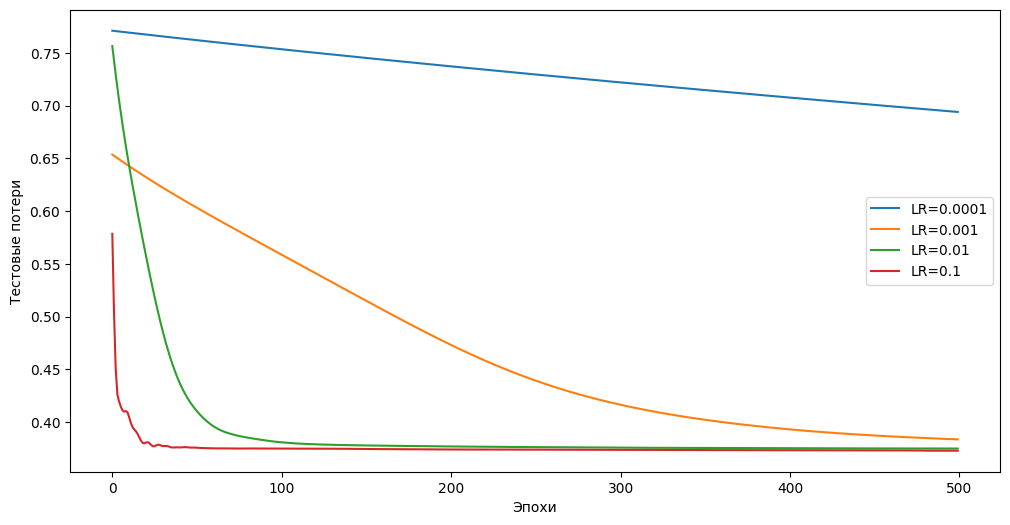

Оптимальный learning_rate: 0.1


In [8]:
#№1 Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, выберите оптимальное значение.
learning_rates = [0.0001, 0.001, 0.01, 0.1]
results_lr = {}

for lr in learning_rates:
    net = Net(input_size=4, hidden_layers=[8])
    criterion = nn.BCELoss()
    train_losses, test_losses, accuracies = train_solve(net, optim.Adam, lr, 500, criterion, device='cpu')
    results_lr[lr] = test_losses

plt.figure(figsize=(12, 6))
for lr, test_losses in results_lr.items():
    plt.plot(test_losses, label=f'LR={lr}')
plt.xlabel('Эпохи')
plt.ylabel('Тестовые потери')
plt.legend()
plt.show()

optimal_lr = min(results_lr, key=lambda lr: min(results_lr[lr]))
print(f"Оптимальный learning_rate: {optimal_lr}")

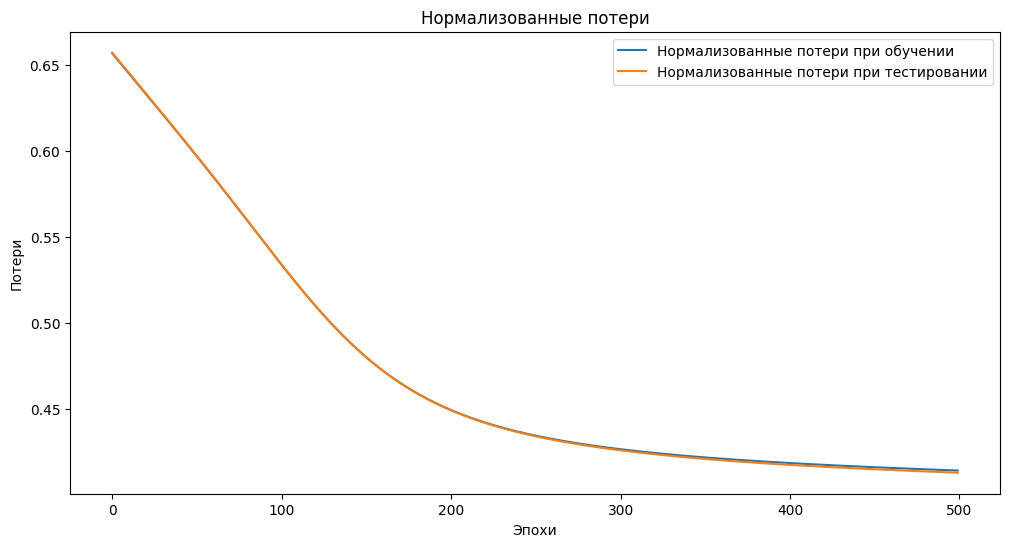

In [9]:
#Примените нормализацию данных. Исследуйте скорость сходимости.
net = Net(input_size=4, hidden_layers=[8])
criterion = nn.BCELoss()
train_losses, test_losses, _ = train_solve(net, optim.Adam, 0.001, 500, criterion, device='cpu')

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Нормализованные потери при обучении')
plt.plot(test_losses, label='Нормализованные потери при тестировании')
plt.title('Нормализованные потери')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

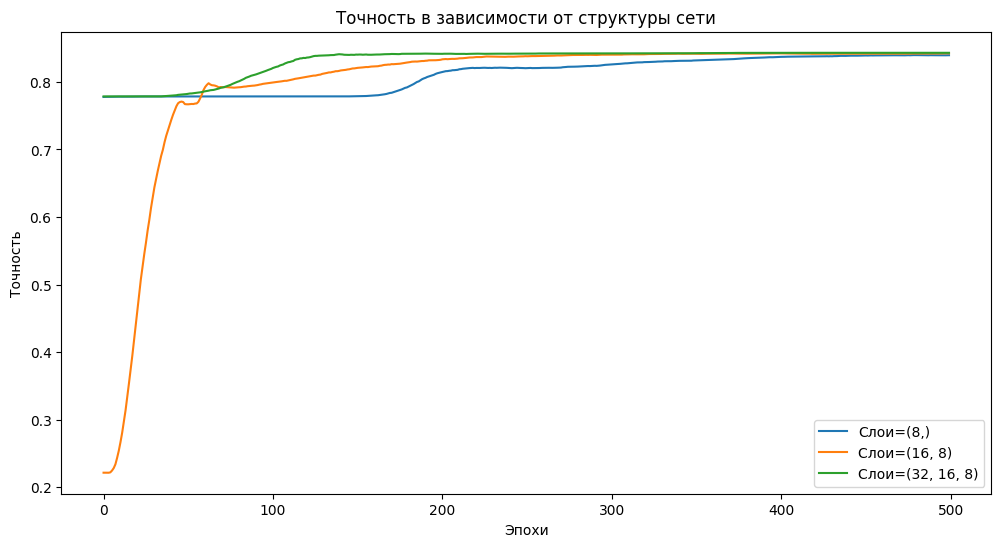

     Структура (8,)  Структура (16, 8)  Структура (32, 16, 8)
0          0.777649           0.221549               0.778451
1          0.777769           0.221549               0.778451
2          0.777849           0.221549               0.778451
3          0.777809           0.221509               0.778451
4          0.777889           0.222031               0.778451
..              ...                ...                    ...
495        0.839402           0.842088               0.842971
496        0.839321           0.842128               0.842971
497        0.839321           0.842128               0.842971
498        0.839402           0.842169               0.842971
499        0.839442           0.842209               0.843011

[500 rows x 3 columns]


In [10]:
#Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.
hidden = [[8], [16, 8], [32, 16, 8]]
results_structure = {}

for structure in hidden:
    net = Net(input_size=4, hidden_layers=structure)
    criterion = nn.BCELoss()
    train_losses, test_losses, accuracies = train_solve(net, optim.Adam, 0.001, 500, criterion, device='cpu')
    results_structure[tuple(structure)] = accuracies

plt.figure(figsize=(12, 6))

for structure, accuracies in results_structure.items():
    plt.plot(accuracies, label=f'Слои={structure}')

plt.title('Точность в зависимости от структуры сети')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

accuracy_data = {
    f'Структура {structure}': accuracies
    for structure, accuracies in results_structure.items()
}

df_accuracy = pd.DataFrame(accuracy_data)
print(df_accuracy)


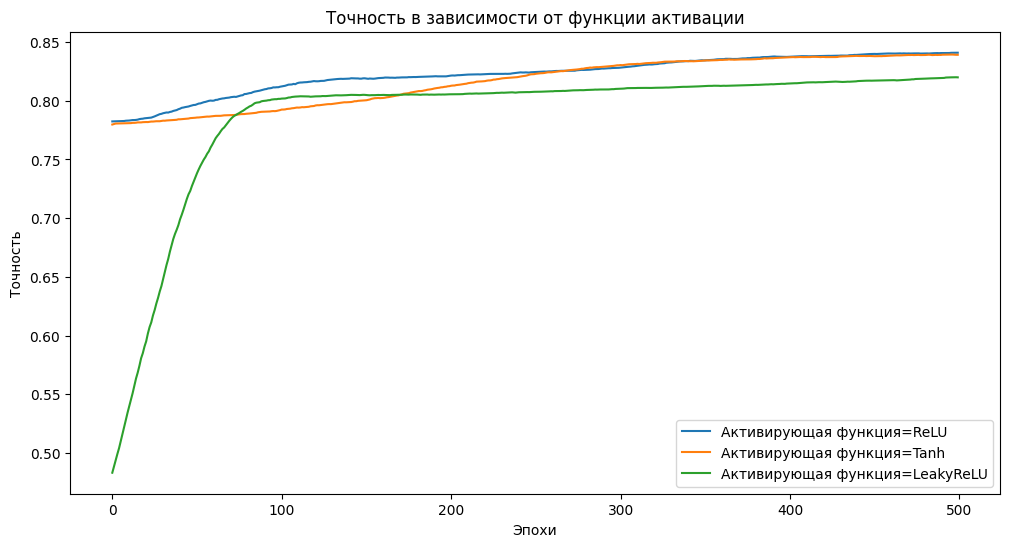

In [11]:
#Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
activations = [nn.ReLU, nn.Tanh, nn.LeakyReLU]
results_activation = {}

for activation in activations:
    net = Net(input_size=4, hidden_layers=[8], activation=activation)
    criterion = nn.BCELoss()
    _, test_losses, accuracies = train_solve(net, optim.Adam, 0.001, 500, criterion, device='cpu')
    results_activation[activation.__name__] = accuracies

plt.figure(figsize=(12, 6))
for activation, accuracies in results_activation.items():
    plt.plot(accuracies, label=f'Активирующая функция={activation}')
plt.title('Точность в зависимости от функции активации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()


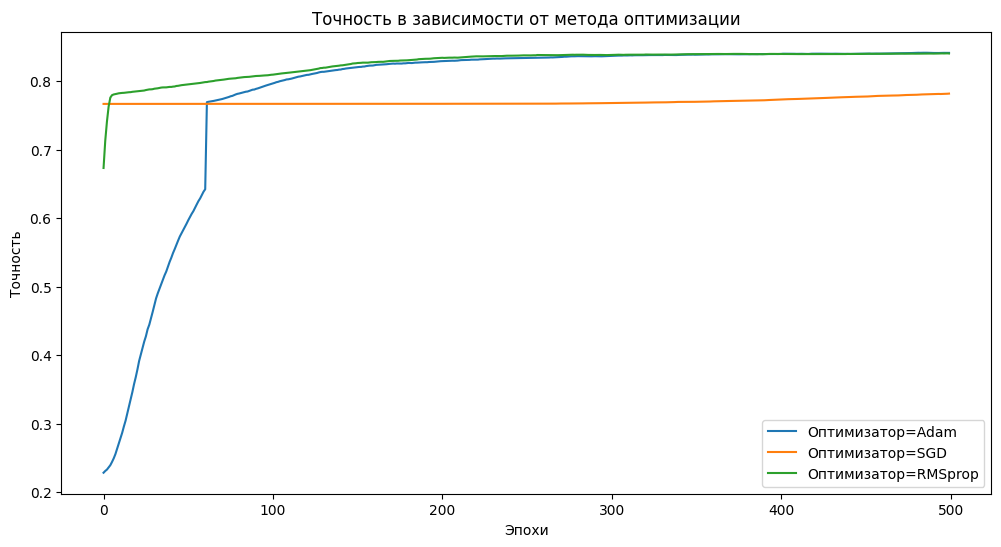

In [12]:
# Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]

results_optim = {}
for optimizer_class in optimizers:
    net = Net(input_size=4, hidden_layers=[8])
    criterion = nn.BCELoss()
    _, test_losses, accuracies = train_solve(net, optimizer_class, 0.001, 500, criterion, device='cpu')
    results_optim[optimizer_class.__name__] = accuracies

plt.figure(figsize=(12, 6))

for optimizer, accuracies in results_optim.items():
    plt.plot(accuracies, label=f'Оптимизатор={optimizer}')

plt.title('Точность в зависимости от метода оптимизации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()


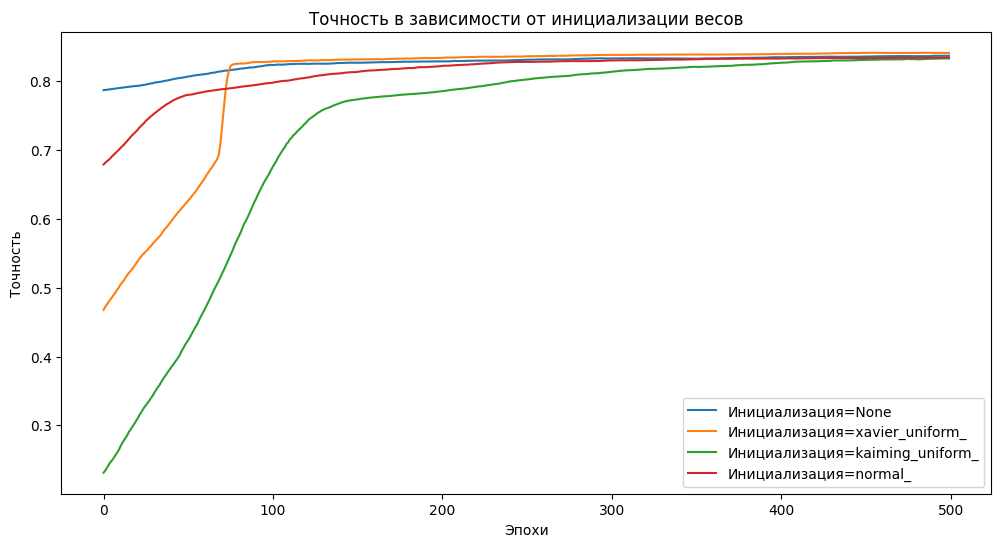

In [13]:
# Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.
initializations = [
    None,
    nn.init.xavier_uniform_,
    nn.init.kaiming_uniform_,
    nn.init.normal_
]
results_init = {}
for init_fn in initializations:
    net = Net(input_size=4, hidden_layers=[8], init_fn=init_fn)
    criterion = nn.BCELoss()
    _, test_losses, accuracies = train_solve(net, optim.Adam, 0.001, 500, criterion, device='cpu')
    results_init[init_fn.__name__ if init_fn else 'None'] = accuracies

plt.figure(figsize=(12, 6))
for init, accuracies in results_init.items():
    plt.plot(accuracies, label=f'Инициализация={init}')
plt.title('Точность в зависимости от инициализации весов')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()
